# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Cкачайте его кстати, 

In [ ]:
!mkdir cifar10
!curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvzf cifar-10-python.tar.gz -C cifar10

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

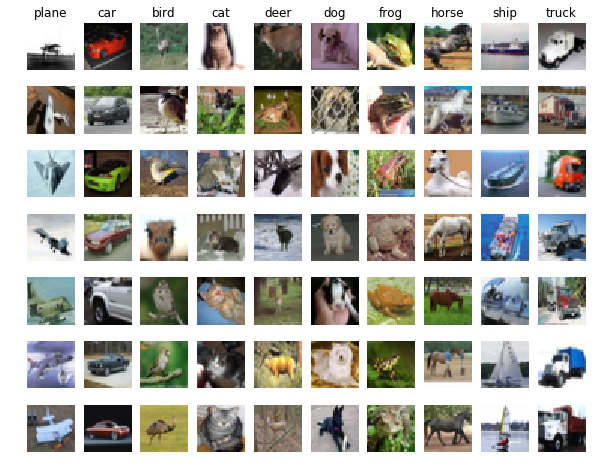

In [3]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').transpose(1, 2, 0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
X_val = X_test[:8000]
y_val = y_test[:8000]
X_test = X_test[8000:]
y_test = y_test[8000:]

<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Чем отличаются современные сверточные сети от сетей 5 летней давности?

<Ответ>

**Вопрос 2**: Какие неприятности могут возникнуть во время обучения современных нейросетей?

<Ответ>


**Вопрос 3**: У вас есть очень маленький датасет из 100 картинок, классификация, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить? что делать если первый вариант  решения не заработает?

<Ответ>

**Вопрос 4**: Как сделать стайл трансфер для музыки? oO

<Ответ>

In [5]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *
from lasagne import init, nonlinearities as nl, layers as ll
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import Pool2DLayer as MaxPool2DLayer
from lasagne.layers import BatchNormLayer 
# from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
# from lasagne.layers.dnn import Pool2DDNNLayer as MaxPool2DLayer
# from lasagne.layers.dnn import BatchNormDNNLayer as BatchNormLayer

Using cuDNN version 5110 on context None
Mapped name None to device cuda0: GRID K520 (0000:00:03.0)


### Соберите нейронку: 
- Many times x (Conv+Pool)
- Many small convolutions like 3x3
- Batch Norm 
- Residual Connection
- Data Augmentation 
- Learning rate Schedule 
- ...

### Для вдохновения 
- http://torch.ch/blog/2015/07/30/cifar.html
- https://github.com/szagoruyko/wide-residual-networks 

### Самое интересное
- Для сдачи задания нужно набрать на точность тесте > **92.5**% (это займет много времени, торопитесь :) )
- Для получения бонусных баллов > **95.0**%
- Будет очень хорошо если вы придумаете свою архитектуру или сможете обучить что-то из вышеперечисленного :)
- А для обучения всего этого добра вам будет куда удобнее использовать GPU на Amazon 
    - Инструкция https://github.com/persiyanov/ml-mipt/tree/master/amazon-howto 
    - Вам помогут tmux, CuDNN, ssh tunnel, nvidia-smi, ... 
    - Have fun :)

In [6]:
input_x, target_y, Winit = T.tensor4("input"), T.vector("target", dtype='int32'), init.Normal()

k = 1

def conv_bn_rectify(net, num_filters):
    net = ConvLayer(net, int(num_filters), 3, W=init.Normal(), pad=1, nonlinearity=None)
    net = BatchNormLayer(net, epsilon=1e-3)
    net = ll.NonlinearityLayer(net)
    return net

net = ll.InputLayer((None, 3, 32, 32), input_x)
net = conv_bn_rectify(net, 64 * k)
net = ll.DropoutLayer(net, 0.3)
net = conv_bn_rectify(net, 64 * k)
net = MaxPool2DLayer(net, 2, 2)

net = conv_bn_rectify(net, 128 * k)
net = ll.DropoutLayer(net, 0.4)
net = conv_bn_rectify(net, 128 * k)
net = MaxPool2DLayer(net, 2, 2)

net = conv_bn_rectify(net, 256 * k)
net = ll.DropoutLayer(net, 0.4)
net = conv_bn_rectify(net, 256 * k)
net = ll.DropoutLayer(net, 0.4)
net = conv_bn_rectify(net, 256 * k)
net = MaxPool2DLayer(net, 2, 2)

net = conv_bn_rectify(net, 512 * k)
net = ll.DropoutLayer(net, 0.4)
net = conv_bn_rectify(net, 512 * k)
net = ll.DropoutLayer(net, 0.4)
net = conv_bn_rectify(net, 512 * k)
net = MaxPool2DLayer(net, 2, 2)

net = conv_bn_rectify(net, 512 * k)
net = ll.DropoutLayer(net, 0.4)
net = conv_bn_rectify(net, 512 * k)
net = ll.DropoutLayer(net, 0.4)
net = conv_bn_rectify(net, 512 * k)
net = MaxPool2DLayer(net, 2, 2)

net = ll.DenseLayer(net, int(512 * k), W=init.Normal(), nonlinearity=nl.rectify)
net = BatchNormLayer(net, epsilon=1e-3)
net = ll.NonlinearityLayer(net)
net = ll.DropoutLayer(net, 0.5)
net = ll.DenseLayer(net, 10, W=init.Normal(), nonlinearity=nl.softmax)

In [7]:
y_predicted = lasagne.layers.get_output(net)
all_weights = lasagne.layers.get_all_params(net, trainable=True)
print all_weights

[W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b]


In [8]:
loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()

In [9]:
from lasagne.updates import nesterov_momentum
learning_rate = 0.001
momentum = 0.9
updates = nesterov_momentum(loss, all_weights, learning_rate=learning_rate, momentum=momentum)
train_fun = theano.function([input_x,target_y],[loss, accuracy], updates=updates, allow_input_downcast=True)
accuracy_fun = theano.function([input_x,target_y], accuracy, allow_input_downcast=True)

### Вот и всё, пошли её учить

In [ ]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Процесс обучения

In [ ]:
import time

num_epochs = 100 #количество проходов по данным

batch_size = 64 #размер мини-батча

for epoch in range(num_epochs):
    if epoch % 10 == 0 and epoch > 0:
        learning_rate /= 10
        momentum *= 0.95
        updates = nesterov_momentum(loss, all_weights, learning_rate=learning_rate, momentum=momentum)
        train_fun = theano.function([input_X,target_y],[loss, accuracy], updates=updates)
        accuracy_fun = theano.function([input_X,target_y],accuracy)
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

Epoch 1 of 100 took 361.544s
  training loss (in-iteration):		1.907802
  train accuracy:		25.02 %
  validation accuracy:		36.19 %
Epoch 2 of 100 took 361.562s
  training loss (in-iteration):		1.502341
  train accuracy:		42.60 %
  validation accuracy:		49.88 %


In [ ]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 92.5:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

## Заполните форму

https://goo.gl/forms/EeadABISlVmdJqgr2 